# Public transport analysis 
Data Science project by Elina Yancheva

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import re
import warnings

In [37]:
df = pd.read_csv('data/transport_data.csv')
display(df.head())

date media_id media_type  product_id  \
0  2024-03-01      NaN        EMV         NaN   
1  2024-03-01      NaN        EMV         NaN   
2  2024-03-01      NaN        EMV         NaN   
3  2024-03-01      NaN        EMV         NaN   
4  2024-03-01      NaN        EMV         NaN   

                                                 pan   tap_lat   tap_lon  \
0  93f70961cd4b34c501fc7a420f9c2a98dda03a1f8f289b...  42.64152  23.38130   
1  2bce4c03b0f8a99ab1578ae65a1a6ef5c53907f0ececf8...  42.64657  23.38381   
2  6c28f31e3df3681b20329845c48966f8b6588cb0277c8d...  42.64340  23.35320   
3  282624b4cd2a6dffa799537e95a64616f1d7ee87891f97...  42.71313  23.37988   
4  282624b4cd2a6dffa799537e95a64616f1d7ee87891f97...  42.70006  23.31014   

   is_network_og transport_type og_line_id  ...  boarding_dist boarding_t  \
0           True            bus       A213  ...         4206.0        894   
1          False          metro        NaN  ...            NaN        780   
2           True     trolleybus      TB123  ...         2169.0        694   
3           True     trolleybus        TB1  ...         3860.0        920   
4          False          metro        NaN  ...            NaN        250   

   is_transfer  transfer_t  transfer_dist        dest_ts  dest_stop_id  \
0         True          55              3  1740825980686         A2327   
1        False        6939              0  1740847050000             8   
2        False       13103             64  1740827981959        TB2791   
3         True         404            261  1740821187813        TB2012   
4        False        7623            443  1740831150000             8   

   dest_stop_lat  dest_stop_lon  \
0       42.67556       23.35889   
1       42.69231       23.33479   
2       42.62461       23.34968   
3       42.69724       23.33787   
4       42.69231       23.33479   

                                                  id  
0  93f70961cd4b34c501fc7a420f9c2a98dda03a1f8f289b...  
1  2bce4c03b0f8a99ab1578ae65a1a6ef5c53907f0ececf8...  
2  6c28f31e3df3681b20329845c48966f8b6588cb0277c8d...  
3  282624b4cd2a6dffa799537e95a64616f1d7ee87891f97...  
4  282624b4cd2a6dffa799537e95a64616f1d7ee87891f97...  

[5 rows x 25 columns]

In [38]:
print("DataFrame Columns:")
for col in df.columns:
    print(" -", col)

DataFrame Columns:
 - date
 - media_id
 - media_type
 - product_id
 - pan
 - tap_lat
 - tap_lon
 - is_network_og
 - transport_type
 - og_line_id
 - origin_ts
 - origin_stop_id
 - origin_stop_lat
 - origin_stop_lon
 - task_id
 - boarding_dist
 - boarding_t
 - is_transfer
 - transfer_t
 - transfer_dist
 - dest_ts
 - dest_stop_id
 - dest_stop_lat
 - dest_stop_lon
 - id


# Data cleaning and preparation

## Invalid entries search

In [39]:
print(f"Dataset shape: {df.shape}")

invalid_data = {
    # Bounds of Sofia region (latitude: 42-43, longitude: 23-24)
    'tap_lat': sum((df['tap_lat'] < 42) | (df['tap_lat'] > 43) | df['tap_lat'].isna()),
    'tap_lon': sum((df['tap_lon'] < 23) | (df['tap_lon'] > 24) | df['tap_lon'].isna()),
    'origin_stop_lat': sum((df['origin_stop_lat'] < 42) | (df['origin_stop_lat'] > 43) | df['origin_stop_lat'].isna()),
    'origin_stop_lon': sum((df['origin_stop_lon'] < 23) | (df['origin_stop_lon'] > 24) | df['origin_stop_lon'].isna()),
    'dest_stop_lat': sum((df['dest_stop_lat'] < 42) | (df['dest_stop_lat'] > 43) | df['dest_stop_lat'].isna()),
    'dest_stop_lon': sum((df['dest_stop_lon'] < 23) | (df['dest_stop_lon'] > 24) | df['dest_stop_lon'].isna()),
    'boarding_t': sum(df['boarding_t'] < 0),
    'transfer_t': sum(df['transfer_t'] < 0),
    'boarding_dist': sum(df['boarding_dist'] < 0),
    'transfer_dist': sum(df['transfer_dist'] < 0),
}

# percentage of invalid data
total_cells = df.shape[0] * df.shape[1]
total_invalid = sum(invalid_data.values())
invalid_percentage = (total_invalid / total_cells) * 100

print("\nInvalid data counts by specific validation rules:")
for col, count in invalid_data.items():
    if count > 0:
        print(f"{col}: {count} invalid values ({(count / len(df)) * 100:.2f}%)")

print(f"\nTotal cells in dataset: {total_cells}")
print(f"Total invalid cells: {total_invalid}")
print(f"Percentage of invalid data: {invalid_percentage:.2f}%")

# origin timestamp should be before destination timestamp
time_inconsistency = sum(df['origin_ts'] >= df['dest_ts'])
print(f"\nRows with origin timestamp >= destination timestamp: {time_inconsistency} ({(time_inconsistency / len(df)) * 100:.2f}%)")

# duplicate IDs
duplicate_ids = df['id'].duplicated().sum()
print(f"Duplicate IDs: {duplicate_ids} ({(duplicate_ids / len(df)) * 100:.2f}%)")

Dataset shape: (55978, 25)

Invalid data counts by specific validation rules:
transfer_t: 236 invalid values (0.42%)

Total cells in dataset: 1399450
Total invalid cells: 236
Percentage of invalid data: 0.02%

Rows with origin timestamp >= destination timestamp: 0 (0.00%)
Duplicate IDs: 23888 (42.67%)


## Unify case

In [40]:
df['transport_type'].value_counts()

transport_type
metro         37751
Bus            5805
Tram           3364
bus            3328
tram           2178
Trolleybus     2077
trolleybus     1472
unknown           3
Name: count, dtype: int64

In [41]:
# drop 3 records (0.005% of dataset) with "unknown" transport type to ensure accurate transport-specific analysis.
df = df[df['transport_type'] != 'unknown']

In [42]:
# convert all transport types to lower case to merge 'Tram' and 'tram' etc.
df['transport_type'] = df['transport_type'].str.lower()

## Negative values search
 Check for negative values in numeric columns where negative values would be problematic

In [43]:

negative_value_checks = {}

# Time-related variables shouldn't be negative
for col in ['boarding_t', 'transfer_t', 'origin_ts', 'dest_ts']:
    if col in df.columns:
        neg_count = (df[col] < 0).sum()
        neg_pct = (df[col] < 0).mean() * 100 if neg_count > 0 else 0
        negative_value_checks[col] = {'count': neg_count, 'percentage': neg_pct}

# Distance-related variables shouldn't be negative
for col in ['boarding_dist', 'transfer_dist']:
    if col in df.columns:
        neg_count = (df[col] < 0).sum()
        neg_pct = (df[col] < 0).mean() * 100 if neg_count > 0 else 0
        negative_value_checks[col] = {'count': neg_count, 'percentage': neg_pct}


print("Negative Value Checks:")
if 'transfer_t' in df.columns and (df['transfer_t'] < -600).sum() > 0:
    print(f"\nExtreme negative transfer times (< -10 min): {(df['transfer_t'] < -600).sum()} records")
    print(f"\nInvalid transfer times by transport type:\n {df[df['transfer_t'] <= 0]['transport_type'].value_counts()}")


# zero transfer time
if 'transfer_t' in df.columns and 'is_transfer' in df.columns:
    zero_transfer_time_count = ((df['is_transfer'] == True) & (df['transfer_t'] == 0)).sum()
    if zero_transfer_time_count > 0:
        print(f"\nTransfers with zero transfer time: {zero_transfer_time_count} records")

Negative Value Checks:

Extreme negative transfer times (< -10 min): 24 records

Invalid transfer times by transport type:
 transport_type
metro         138
bus            70
trolleybus     22
tram           12
Name: count, dtype: int64

Transfers with zero transfer time: 6 records


## Duplicate IDs search

In [44]:
duplicate_ids = df['id'].value_counts()
duplicate_ids = duplicate_ids[duplicate_ids > 1]

print(f"Number of unique IDs that appear multiple times: {len(duplicate_ids)}")
print(f"Total number of rows with duplicate IDs: {sum(duplicate_ids) - len(duplicate_ids)}")

# For each duplicate ID, check if the rows are identical
print("\nAnalyzing duplicate ID rows:")
identical_dupes = 0
different_dupes = 0
dupe_analysis = {}

for current_id in duplicate_ids.index:
    id_rows = df[df['id'] == current_id]
    
    # First, reset the index to avoid comparing index values
    id_rows_reset = id_rows.reset_index(drop=True)
    
    # Check if all rows are identical
    all_identical = id_rows_reset.iloc[0:1].equals(id_rows_reset)
    
    # If not all identical, find which columns differ
    if not all_identical:
        different_dupes += 1
    else:
        identical_dupes += 1

print(f"\nOut of {len(duplicate_ids)} IDs with duplicates:")
print(f"- {identical_dupes} IDs have completely identical rows")
print(f"- {different_dupes} IDs have differences between rows")

# are there multiple unique dates in the dataset
unique_dates = df['date'].nunique()
if unique_dates == 1:
    print(f"The dataset contains a single date: {df['date'].iloc[0]}")
else:
    # check if duplicates occur within the same day
    if 'date' in df.columns:
        same_day_dupes = 0
        for current_id in duplicate_ids.index:
            dates = df[df['id'] == current_id]['date'].unique()
            if len(dates) == 1:
                same_day_dupes += 1
        
        print(f"\nDuplicate IDs occurring on the same day: {same_day_dupes} ({same_day_dupes/len(duplicate_ids)*100:.1f}%)")
        print(f"Duplicate IDs occurring across different days: {len(duplicate_ids) - same_day_dupes} ({(len(duplicate_ids) - same_day_dupes)/len(duplicate_ids)*100:.1f}%)")

Number of unique IDs that appear multiple times: 13229
Total number of rows with duplicate IDs: 23885

Analyzing duplicate ID rows:

Out of 13229 IDs with duplicates:
- 0 IDs have completely identical rows
- 13229 IDs have differences between rows
The dataset contains a single date: 2024-03-01


All duplicate IDs (13,230 unique IDs appearing 23,888 times) represent different transport journeys rather than identical data entries. Since these represent legitimate separate journeys might have been made by the same user/card, we will retain all rows in our analysis without filtering for unique IDs.

In [45]:
duplicate_id_values = duplicate_ids.index.tolist()

df_duplicates = df[df['id'].isin(duplicate_id_values)]

transfer_counts = df_duplicates['is_transfer'].value_counts(normalize=True) * 100

print(f"Total rows with duplicate IDs: {len(df_duplicates)}")
print(f"Percentage of duplicate ID rows where is_transfer = True: {transfer_counts.get(True, 0):.2f}%")
print(f"Percentage of duplicate ID rows where is_transfer = False: {transfer_counts.get(False, 0):.2f}%")

# transfer patterns by journey sequence
print("\nAnalyzing transfer patterns by journey sequence:")
sequence_patterns = {}

for id_val in duplicate_ids.index:
    # rows for this ID, SORTED BY ORIGIN TIMESTAMP
    id_rows = df[df['id'] == id_val].sort_values('origin_ts')
    
    # pattern of transfers (T = transfer, N = non-transfer)
    pattern = ''.join(['T' if x else 'N' for x in id_rows['is_transfer']])
    
    if pattern in sequence_patterns:
        sequence_patterns[pattern] += 1
    else:
        sequence_patterns[pattern] = 1

print("\nMost common transfer patterns (T=transfer, N=non-transfer):")
for pattern, count in sorted(sequence_patterns.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{pattern}: {count} IDs ({count/len(duplicate_ids)*100:.2f}%)")

Total rows with duplicate IDs: 37114
Percentage of duplicate ID rows where is_transfer = True: 46.61%
Percentage of duplicate ID rows where is_transfer = False: 53.39%

Analyzing transfer patterns by journey sequence:

Most common transfer patterns (T=transfer, N=non-transfer):
TN: 4500 IDs (34.02%)
NN: 1641 IDs (12.40%)
TNT: 965 IDs (7.29%)
NT: 825 IDs (6.24%)
TNN: 564 IDs (4.26%)
TT: 521 IDs (3.94%)
NNN: 514 IDs (3.89%)
NTN: 369 IDs (2.79%)
TNTN: 358 IDs (2.71%)
TTN: 308 IDs (2.33%)


### Transfer Pattern Analysis for Duplicate IDs
Check if all duplicate ids involve transfers, to check if a single journey with many segments is represented by multiple rows or if they are different journeys with the same ID. 

Analysis of the 37,118 journeys with duplicate IDs reveals that 46.61% involve transfers, with the most common pattern (34.01%) being a transfer followed by a non-transfer journey (TN). This suggests that many users make connected trips where they transfer once and then complete their journey directly, while the presence of various multi-segment patterns (TNT, TNN, TNTN) indicates more complex travel behaviors spanning multiple transit modes. The following analysis assumes that all duplicate IDs represent different journeys, by the same person. 

## Missing values

In [46]:
# converting millisecond timestamps to datetime
df['dest_datetime'] = pd.to_datetime(df['dest_ts'], unit='ms')
df['hour_of_day'] = df['dest_datetime'].dt.hour if 'dest_datetime' in df.columns else None

for col in df.columns:
    missing_pct = df[col].isnull().mean() * 100
    if missing_pct > 0:
        print(f"{col}: {missing_pct:.2f}% missing")

media_id: 23.64% missing
product_id: 79.65% missing
pan: 76.36% missing
og_line_id: 67.44% missing
task_id: 67.44% missing
boarding_dist: 67.44% missing


In [47]:
# Head of lines with missing og_line_id
missing_og_line = df[df['og_line_id'].isnull()]
print(missing_og_line['transport_type'].value_counts())
print("---")
print(f"All metro records don't have og_line_id: \
       {df[df['transport_type'] == 'metro']['og_line_id'].isnull().sum() == df[df['transport_type'] == 'metro'].shape[0]}")

transport_type
metro    37751
Name: count, dtype: int64
---
All metro records don't have og_line_id:        True


In [48]:
# for each column with significant missing data, check transport type distribution
for col in ['media_id', 'product_id', 'pan', 'og_line_id', 'task_id', 'boarding_dist']:
    print(f"\nMissing {col} by transport type:")
    print(df[df[col].isnull()]['transport_type'].value_counts())


Missing media_id by transport type:
transport_type
metro         6397
bus           3243
tram          2140
trolleybus    1451
Name: count, dtype: int64

Missing product_id by transport type:
transport_type
metro         37751
bus            3243
tram           2140
trolleybus     1451
Name: count, dtype: int64

Missing pan by transport type:
transport_type
metro         31354
bus            5890
tram           3402
trolleybus     2098
Name: count, dtype: int64

Missing og_line_id by transport type:
transport_type
metro    37751
Name: count, dtype: int64

Missing task_id by transport type:
transport_type
metro    37751
Name: count, dtype: int64

Missing boarding_dist by transport type:
transport_type
metro    37751
Name: count, dtype: int64


**Metro** has the most missing data across all fields, with complete absence of `product_id`, `og_line_id`, `task_id`, and `boarding_dist` values. This suggests metro journeys are tracked differently in the system.

In [49]:
print("Value counts for dest_datetime (date only):")
print(df['dest_datetime'].dt.date.value_counts())

print("\nValue counts for date:")
print(df['date'].value_counts())

Value counts for dest_datetime (date only):
dest_datetime
2025-03-01    55973
2025-03-02        2
Name: count, dtype: int64

Value counts for date:
date
2024-03-01    55975
Name: count, dtype: int64


### Date Inconsistency Analysis

While all records show the journey date as `2024-03-01`, the destination timestamps overwhelmingly resolve to `2025-03-01`  with two outliers on `2025-03-02` (maybe short after midnight). This one-year difference between `date` (journey dates) and destination timestamps indicates a systematic timestamp error.

# Exploratory data analysis

## Transport type distribution

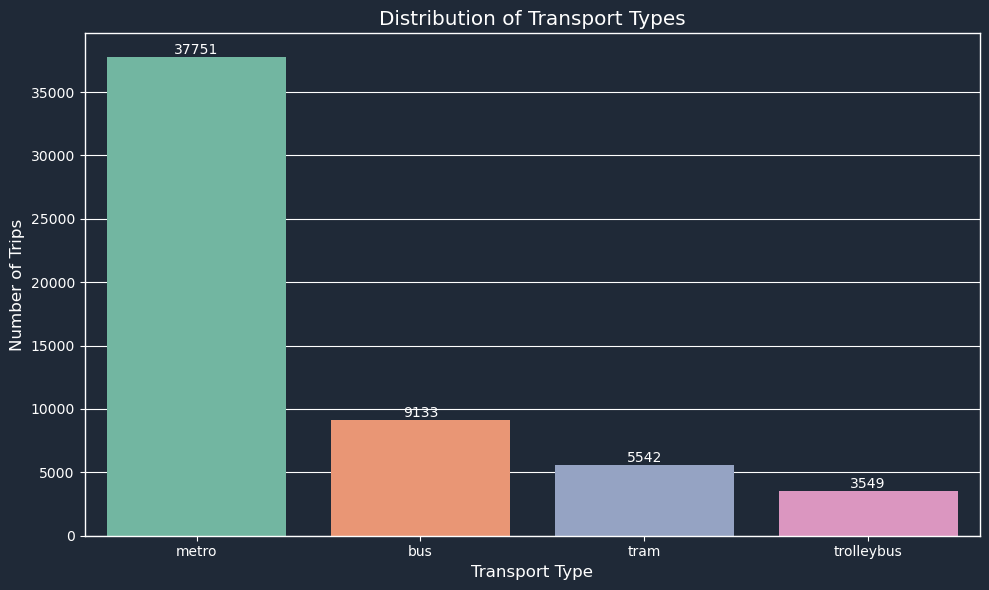

In [50]:
transport_counts = df['transport_type'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6), facecolor='#1f2937')
ax.set_facecolor('#1f2937')

sns.barplot(x=transport_counts.index, y=transport_counts.values, ax=ax)

ax.set_title('Distribution of Transport Types', color="white")
ax.set_xlabel('Transport Type', color="white")
ax.set_ylabel('Number of Trips', color="white")
ax.tick_params(colors='white')

# Add bar values (with white text)
for i, v in enumerate(transport_counts.values):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', color='white')

plt.tight_layout()
plt.show()

## Transport type distribution by line number


Most Frequent Line IDs by Transport Type


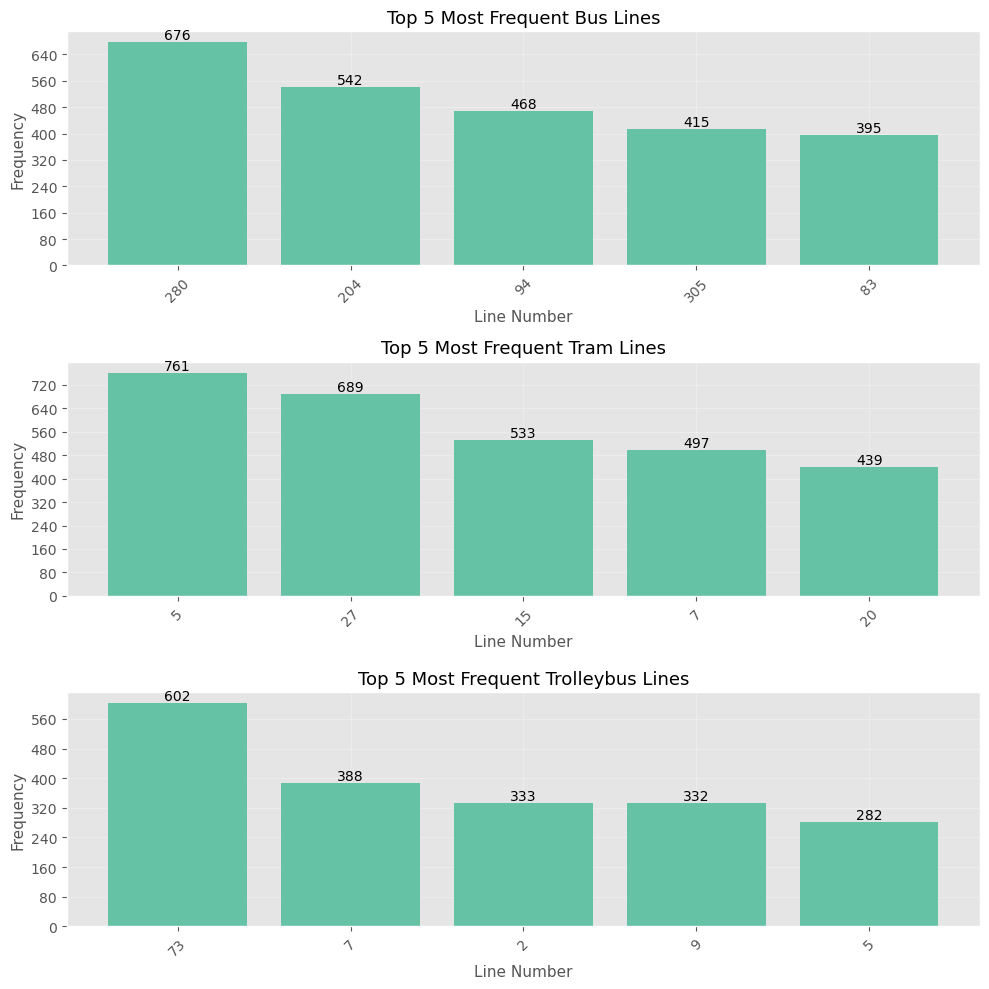

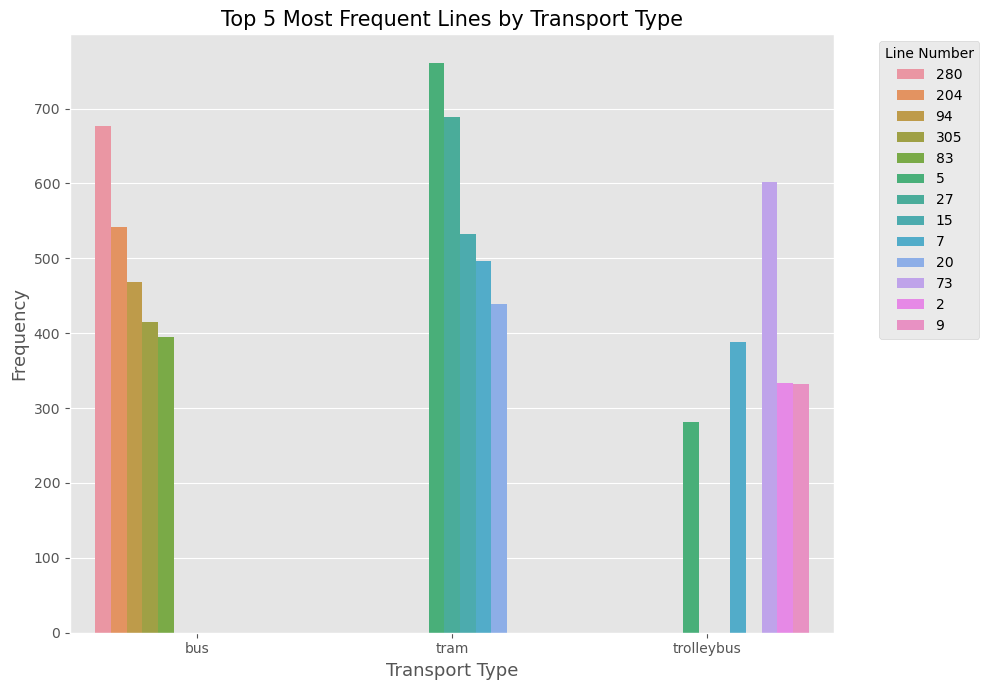

In [51]:
warnings.filterwarnings("ignore", message="The figure layout has changed to tight")

plt.style.use('ggplot')
sns.set_palette("Set2")

transport_types = ['bus', 'tram', 'trolleybus']
filtered_df = df[df['transport_type'].isin(transport_types)].copy()

def extract_line_number(row):
    """Extract numeric part from line_id based on transport type"""
    line_id = str(row['og_line_id'])
    # Extract numbers from the line_id
    matches = re.findall(r'\d+', line_id)
    if matches:
        return matches[0]  # Return the first number found
    return line_id  # Return original if no number found

filtered_df.loc[:, 'line_number'] = filtered_df.apply(extract_line_number, axis=1)

print("\nMost Frequent Line IDs by Transport Type")

results = {}
for transport_type in transport_types:
    if transport_type in filtered_df['transport_type'].values:
        # Filter current transport type
        type_df = filtered_df[filtered_df['transport_type'] == transport_type]
        
        # Count line_number frequencies
        line_counts = type_df['line_number'].value_counts()
        
        results[transport_type] = line_counts
    else:
        print(f"\nNo data available for {transport_type}")

plt.figure(figsize=(10, 10))

for i, transport_type in enumerate(results.keys(), 1):
    if len(results[transport_type]) > 0:
        top_lines = results[transport_type].head(5)
        
        plt.subplot(len(results), 1, i)
        
        bars = plt.bar(top_lines.index.astype(str), top_lines.values)
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom')
        
        plt.title(f'Top 5 Most Frequent {transport_type.capitalize()} Lines', fontsize=13)
        plt.xlabel('Line Number', fontsize=11)
        plt.ylabel('Frequency', fontsize=11)
        plt.xticks(rotation=45)
        plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

combined_data = []
for transport_type, line_counts in results.items():
    if len(line_counts) > 0:
        top_5 = line_counts.head(5)
        for line_id, count in top_5.items():
            combined_data.append({
                'Transport Type': transport_type,
                'Line Number': str(line_id),
                'Frequency': count
            })

combined_df = pd.DataFrame(combined_data)

if len(combined_df) > 0:
    plt.figure(figsize=(10, 7))
    
    ax = sns.barplot(x='Transport Type', y='Frequency', hue='Line Number', data=combined_df)
    
    plt.title('Top 5 Most Frequent Lines by Transport Type', fontsize=15)
    plt.xlabel('Transport Type', fontsize=13)
    plt.ylabel('Frequency', fontsize=13)
    plt.legend(title='Line Number', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()


In [52]:
print("\n Summary of the day")
for transport_type in results.keys():
    if len(results[transport_type]) > 0:
        top_line = results[transport_type].idxmax()
        top_count = results[transport_type].max()
        total_trips = results[transport_type].sum()
        top_percentage = (top_count / total_trips) * 100
        
        print(f"\n{transport_type.capitalize()}:")
        print(f"- Most frequent line: {top_line} with {top_count} trips ({top_percentage:.1f}% of all {transport_type} trips)")
        print(f"- Total number of unique lines: {len(results[transport_type])}")
        print(f"- Total trips recorded: {total_trips}")


 Summary of the day

Bus:
- Most frequent line: 280 with 676 trips (7.4% of all bus trips)
- Total number of unique lines: 78
- Total trips recorded: 9133

Tram:
- Most frequent line: 5 with 761 trips (13.7% of all tram trips)
- Total number of unique lines: 16
- Total trips recorded: 5542

Trolleybus:
- Most frequent line: 73 with 602 trips (17.0% of all trolleybus trips)
- Total number of unique lines: 16
- Total trips recorded: 3549


## Trip timing analysis

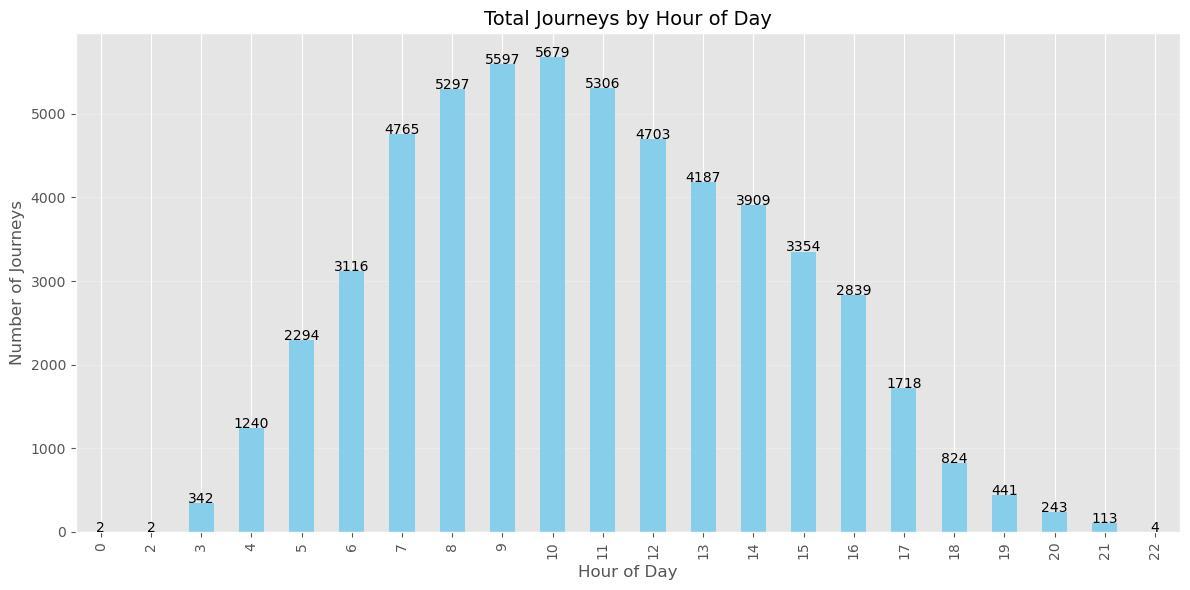

In [53]:
# Convert timestamp to datetime
df['origin_datetime'] = pd.to_datetime(df['origin_ts'], unit='ms')

# Extract hour from timestamp if not already done
if 'hour_of_day' not in df.columns:
    df['hour_of_day'] = df['origin_datetime'].dt.hour

# Calculate hourly distribution by transport type
hourly_by_transport = df.groupby(['hour_of_day', 'transport_type']).size().unstack(fill_value=0)

hourly_total = df.groupby('hour_of_day').size()

fig1, ax1 = plt.subplots(figsize=(12, 6))
hourly_total.plot(kind='bar', color='skyblue', ax=ax1)
ax1.set_title('Total Journeys by Hour of Day', fontsize=14)
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Number of Journeys', fontsize=12)
ax1.grid(True, axis='y', alpha=0.3)

# Add text labels
for i, v in enumerate(hourly_total):
    ax1.text(i, v + 0.1, str(v), ha='center')

plt.tight_layout()
plt.show()

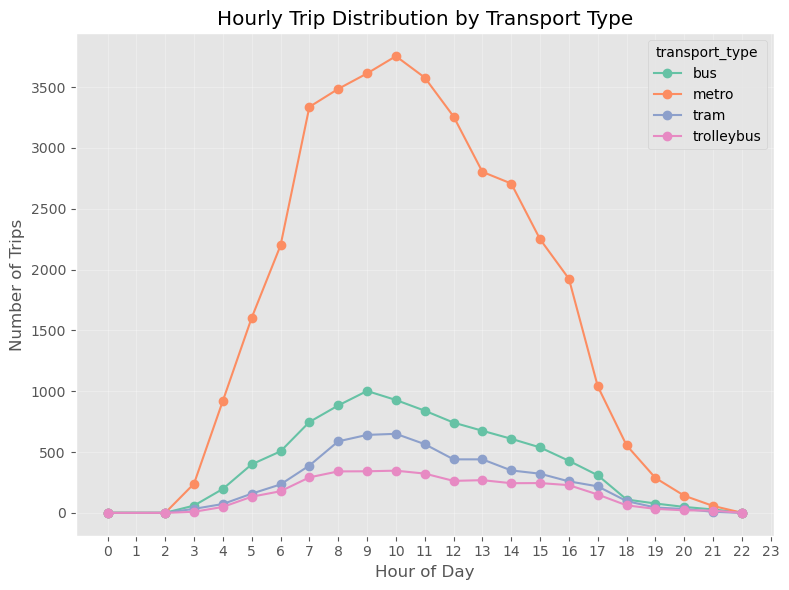

In [54]:
fig2, ax2 = plt.subplots(figsize=(8, 6))
hourly_trips = df.groupby(['hour_of_day', 'transport_type']).size().unstack().fillna(0)
hourly_trips.plot(kind='line', marker='o', ax=ax2)
ax2.set_title('Hourly Trip Distribution by Transport Type')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Number of Trips')
ax2.set_xticks(range(0, 24))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Transport Usage Analysis Summary

**Hourly Usage Patterns:**
- Clear morning peak (8-12) for all transport modes
- Metro volumes significantly exceed all other transportation types

## Transfer Analysis 

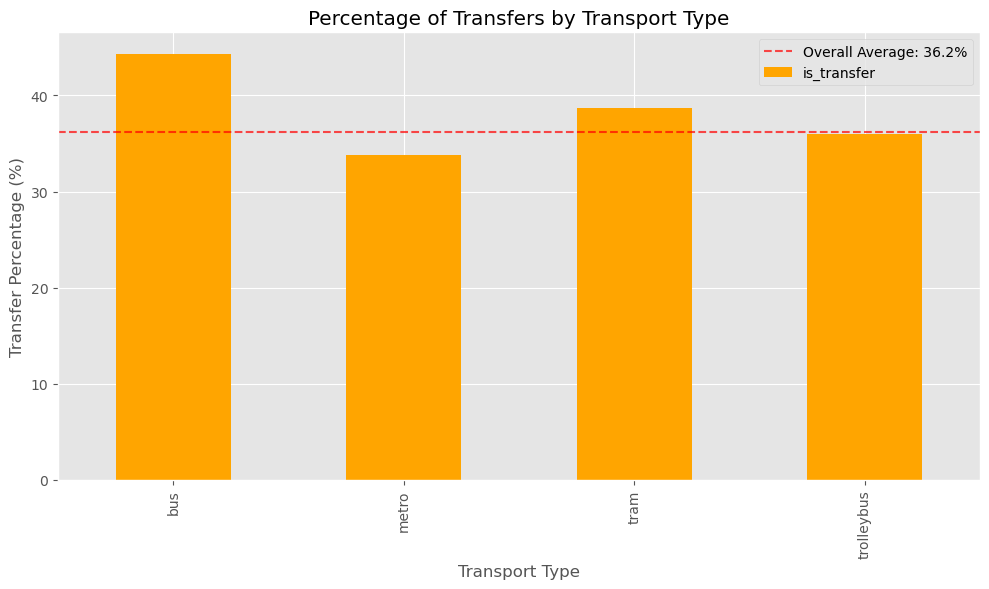

In [55]:
transfer_stats = df.groupby('transport_type')['is_transfer'].mean() * 100
plt.figure(figsize=(10, 6))
transfer_stats.plot(kind='bar', color='orange')
plt.title('Percentage of Transfers by Transport Type')
plt.ylabel('Transfer Percentage (%)')
plt.xlabel('Transport Type')
plt.axhline(y=df['is_transfer'].mean()*100, color='red', linestyle='--', alpha=0.7, 
            label=f'Overall Average: {df["is_transfer"].mean()*100:.1f}%')
plt.legend()
plt.tight_layout()
plt.show()


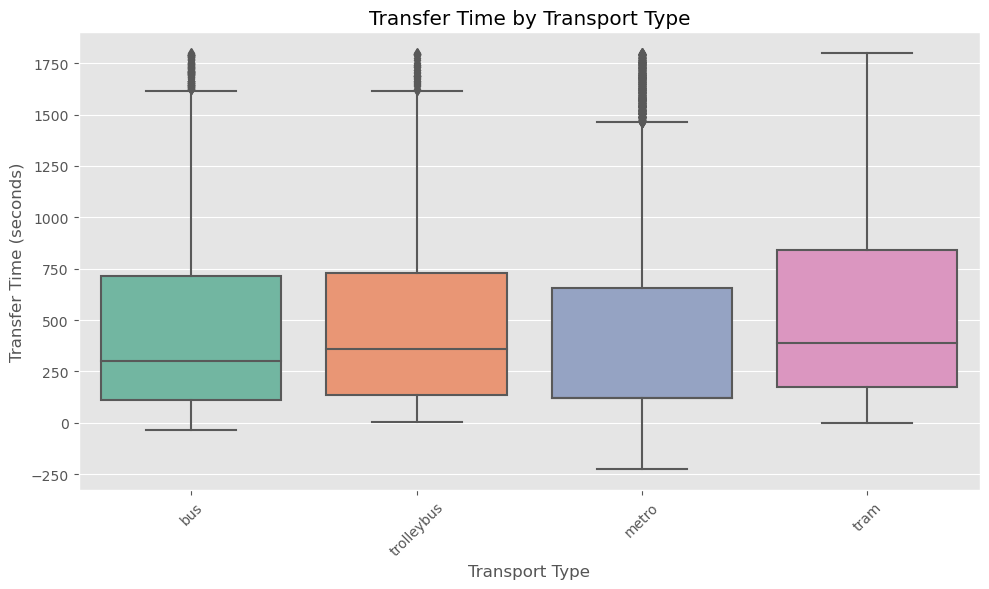

Average transfer waiting time: 7.45 minutes


In [56]:
# transfer time analysis
if 'transfer_t' in df.columns:
    # Filter for trips with transfers and avoid invalid transfer times
    transfer_trips = df[df['is_transfer'] == True & (df['transfer_t'] > 0)]
    
    # transfer time by transport type
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='transport_type', y='transfer_t', data=transfer_trips)
    plt.title('Transfer Time by Transport Type')
    plt.ylabel('Transfer Time (seconds)')
    plt.xlabel('Transport Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # efficiency metrics
    avg_transfer_time = df[df['is_transfer']]['transfer_t'].mean() / 60  # minutes
    print(f"Average transfer waiting time: {avg_transfer_time:.2f} minutes")

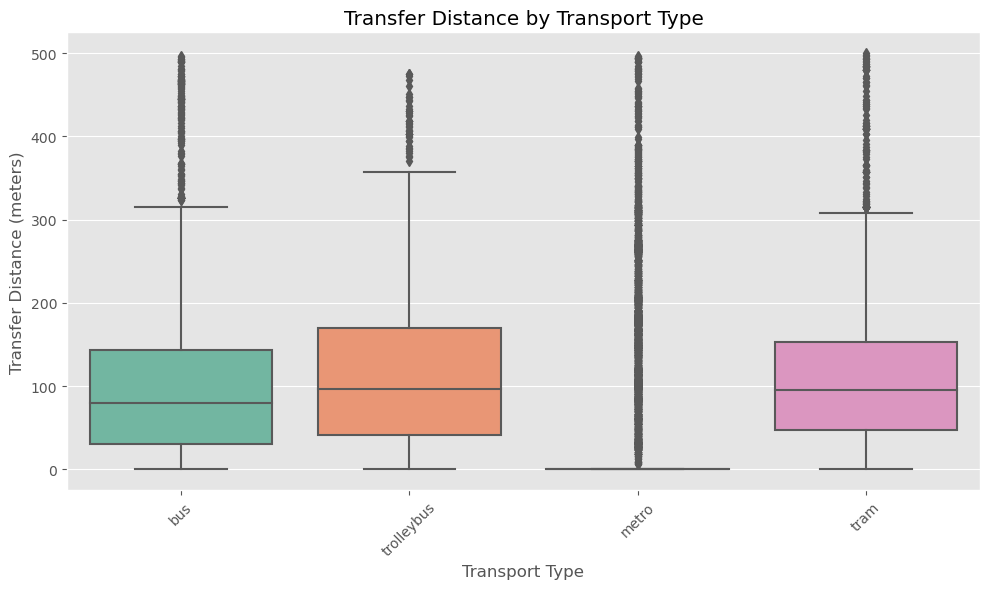

Average transfer distance: 0.06 kilometers


In [57]:

# transfer disance analysis
if 'transfer_dist' in df.columns:
    transfer_trips = df[df['is_transfer'] == True]
    
    # transfer distance by transport type
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='transport_type', y='transfer_dist', data=transfer_trips)
    plt.title('Transfer Distance by Transport Type')
    plt.ylabel('Transfer Distance (meters)')
    plt.xlabel('Transport Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # calculate efficiency metrics
    avg_transfer_distance = df[df['is_transfer']]['transfer_dist'].mean() / 1000  # kilometers
    print(f"Average transfer distance: {avg_transfer_distance:.2f} kilometers")

### Transfer Analysis Insights

#### Transfer Frequency
- **Bus** has the highest transfer rate at ~44%, significantly above the overall average of 36.2%.
- **Metro** has the lowest transfer rate at ~34%, suggesting it may serve more direct routes or complete journeys.
- **Tram** and **Trolleybus** show transfer rates close to or slightly below the overall average.

#### Transfer Time
- **Transfer times** typically range from ~150-750 seconds (2.5-12.5 minutes) across all transport types.
- **Tram** shows the highest median transfer time, suggesting potentially less frequent service.
- **Metro** displays notable outliers with some negative transfer times, indicating potential data quality issues or system timing anomalies.

#### Transfer Distance
- **Trolleybus** transfers involve the longest distances (median ~100m).
- **Metro** shows a weird distribution with many transfers happening at very short distances (0-1m) but also having numerous outliers stretching to 500m.
- **Bus** and **Tram** show similar distance distributions with medians around 75-100m.

These patterns suggest that while metro is the dominant transport mode, bus connections play a crucial role in the overall network connectivity. The presence of negative transfer times and the unusual metro distance distribution suggest further investigation into data quality and how transfers are recorded in the system. 

## Geospatial analysis 

In [58]:
# create a map of all trip origins
m = folium.Map(location=[df['tap_lat'].mean(), df['tap_lon'].mean()], zoom_start=12)

# heatmap layer
heat_data = [[row['tap_lat'], row['tap_lon']] for _, row in df.iterrows()]
HeatMap(heat_data).add_to(m)

transport_colors = {
    'bus': 'blue',
    'metro': 'red',
    'trolleybus': 'green',
    'tram':  'orange'
}

m2 = folium.Map(location=[df['tap_lat'].mean(), df['tap_lon'].mean()], zoom_start=12)

# add SMALL SAMPLE of points colored by transport type 
sample_size = min(1000, len(df))
for _, row in df.sample(sample_size).iterrows():
    color = transport_colors.get(row['transport_type'], 'gray')
    folium.CircleMarker(
        location=[row['tap_lat'], row['tap_lon']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=row['transport_type']
    ).add_to(m2)

legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; 
padding: 10px; border: 2px solid grey; border-radius: 5px;">
<p><b>Transport Type</b></p>
'''
for transport, color in transport_colors.items():
    legend_html += f'<p><i class="fa fa-circle" style="color:{color}"></i> {transport}</p>'
legend_html += '</div>'

m2.get_root().html.add_child(folium.Element(legend_html))

display(m)

In [59]:
display(m2)

In [60]:
from folium.plugins import HeatMapWithTime

m4 = folium.Map(location=[df['origin_stop_lat'].mean(), df['origin_stop_lon'].mean()], zoom_start=12)

# Create a column for hour if it doesn't exist yet
if 'hour' not in df.columns and 'dest_datetime' in df.columns:
    df['hour'] = df['dest_datetime'].dt.hour
elif 'hour' not in df.columns and 'origin_ts' in df.columns:
    df['origin_datetime'] = pd.to_datetime(df['origin_ts'], unit='ms')
    df['hour'] = df['origin_datetime'].dt.hour

heat_data_by_hour = []
hour_labels = []

# Process data for each hour
for hour in range(24):
    hour_data = df[df['hour'] == hour]
    
    hour_heat_data = [[row['origin_stop_lat'], row['origin_stop_lon'], 1] for _, row in hour_data.iterrows()]
    heat_data_by_hour.append(hour_heat_data)
    
    hour_labels.append(f"{hour}:00")

HeatMapWithTime(
    heat_data_by_hour,
    index=hour_labels,
    auto_play=True,
    max_opacity=0.8,
    radius=15,
    gradient={
        0.2: 'blue',
        0.4: 'lime',
        0.6: 'yellow',
        0.8: 'orange',
        1.0: 'red'
    },
    min_opacity=0.5,
    use_local_extrema=True  
).add_to(m4)

title_html = '''
<div style="position: fixed; top: 10px; left: 50%; transform: translateX(-50%); 
background-color: white; padding: 10px; border: 2px solid grey; border-radius: 5px; z-index: 1000;">
<h3>Public Transport Usage by Hour (origin locations)</h3>
</div>
'''
m4.get_root().html.add_child(folium.Element(title_html))
display(m4)

# Commuters vs occasional users

## User identifiers

In [61]:
media_type_counts = df['media_type'].value_counts()
print("Records by media type:")
display(media_type_counts)

summary_df = pd.DataFrame(columns=['Media Type', 'Has PAN', 'Has Media ID'])

print("\nDistribution by Media Type and ID Type:")
distribution_df = pd.DataFrame(index=df['media_type'].unique())

# records with PAN for each media type
distribution_df['With PAN'] = [df[(df['media_type'] == mt) & (df['pan'].notna())].shape[0] 
                              for mt in distribution_df.index]

# records with media_id for each media type
if 'media_id' in df.columns:
    distribution_df['With Media ID'] = [df[(df['media_type'] == mt) & (df['media_id'].notna())].shape[0] 
                                      for mt in distribution_df.index]

distribution_df['Total Records'] = [df[df['media_type'] == mt].shape[0] for mt in distribution_df.index]
display(distribution_df)

Records by media type:


media_type
desfire    41499
EMV        13231
ulc         1245
Name: count, dtype: int64


Distribution by Media Type and ID Type:


With PAN  With Media ID  Total Records
EMV         13231              0          13231
desfire         0          41499          41499
ulc             0           1245           1245

Summary of user identifiers:
- EMV cards use PAN (payment card numbers)
- Desfire and ULC cards use Media ID
- No card type uses both identifiers
- all cards have unique identifiers

Combine both identifiers into a single column for analysis.

In [62]:
df['user_identifier'] = df.apply(
    lambda row: row['pan'] if pd.notna(row['pan']) else row['media_id'], 
    axis=1
)

In [63]:
# Segment users based on frequency
user_freq = df.groupby('user_identifier').size().reset_index(name='journey_count')
user_freq['user_type'] = pd.cut(
    user_freq['journey_count'], 
    bins=[0, 2, 4, 10, float('inf')],
    labels=['One-time', 'Regular', 'Frequent', 'Very Frequent'],
    right=False  # Ensure the bins are inclusive on the left
)
# Ensure 'user_type' is a categorical column
user_freq['user_type'] = user_freq['user_type'].astype('category')

for label in user_freq['user_type'].cat.categories:
    if label == 'One-time':
        print(f"{label}: Users who traveled only once.")
    elif label == 'Regular':
        print(f"{label}: Users who traveled 2-3 times.")
    elif label == 'Frequent':
        print(f"{label}: Users who traveled 4-9 times.")
    elif label == 'Very Frequent':
        print(f"{label}: Users who traveled more than 10 times.\n")

# count users in each segment
user_segment_counts = user_freq['user_type'].value_counts().sort_index()
print("User segments based on journey count:")
for segment, count in user_segment_counts.items():
    print(f"{segment}: {count} users ({count/len(user_freq)*100:.1f}%)")

# join user frequency 
df = df.merge(user_freq[['user_identifier', 'journey_count', 'user_type']], on='user_identifier', how='left')

# extract hour and determine if peak hours
df['hour'] = df['origin_datetime'].dt.hour
df['is_morning_peak'] = df['hour'].between(6, 9)
df['is_evening_peak'] = df['hour'].between(16, 19)
df['is_peak_hour'] = df['is_morning_peak'] | df['is_evening_peak']

# Identify commuter patterns
# Commuters: Users who travel back from origin to destination 
user_commute_ratio = df.groupby('user_identifier').agg(
    morning_peak=('is_morning_peak', 'any'),
    evening_peak=('is_evening_peak', 'any')
).reset_index()

user_commute_ratio.head()
user_commute_ratio['is_commuter'] = user_commute_ratio['morning_peak'] & user_commute_ratio['evening_peak']
print(f"\nCommuter ratio: {user_commute_ratio['is_commuter'].mean() * 100:.2f}% of users are commuters")


One-time: Users who traveled only once.
Regular: Users who traveled 2-3 times.
Frequent: Users who traveled 4-9 times.
Very Frequent: Users who traveled more than 10 times.

User segments based on journey count:
One-time: 18861 users (58.8%)
Regular: 10618 users (33.1%)
Frequent: 2575 users (8.0%)
Very Frequent: 36 users (0.1%)

Commuter ratio: 2.00% of users are commuters


In [64]:
# Analyze EMV card usage compared to other types
card_type_counts = df['media_type'].value_counts()
total_users = len(df)
emv_percentage = (card_type_counts.get('EMV', 0) / total_users) * 100
other_percentage = 100 - emv_percentage

print(f"EMV card usage: {emv_percentage:.1f}%")
print(f"Other card types: {other_percentage:.1f}%")

EMV card usage: 23.6%
Other card types: 76.4%


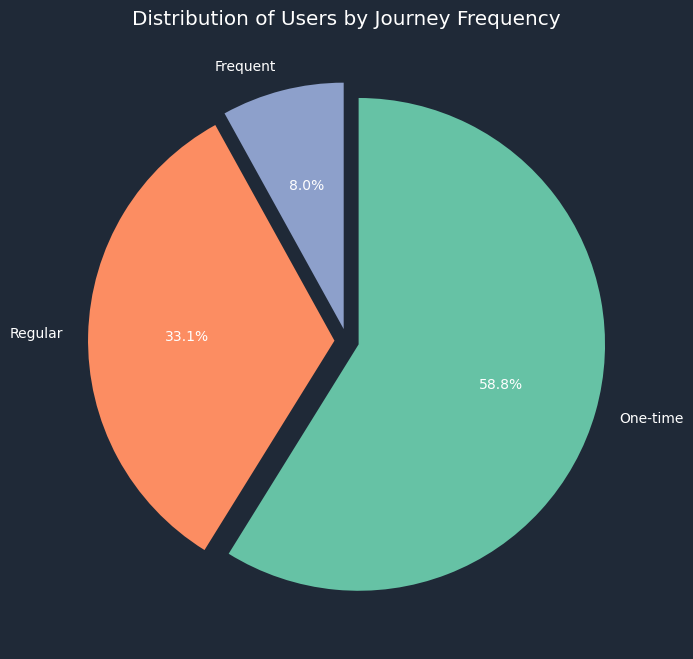

In [65]:
total = user_segment_counts.sum()
percentages = (user_segment_counts / total) * 100

# filter out segments with less than 1%
filtered_counts = user_segment_counts[percentages >= 1]

plt.figure(figsize=(8, 8), facecolor='#1f2937')
explode = [0.05] * len(filtered_counts)

def autopct_func(pct):
    return '{:.1f}%'.format(pct) if pct >= 1 else ''

ax = filtered_counts.plot.pie(
    autopct=autopct_func,
    startangle=90,
    counterclock=False,
    explode=explode,
    textprops={'color': 'white'},
    figsize=(8, 8)
)
ax.set_facecolor('#1f2937')
plt.title('Distribution of Users by Journey Frequency', color='white')
plt.ylabel('')
plt.show()


## Weekend Public Transport Usage Patterns

The Saturday data reveals predominantly one-time travelers (58.8%) and regular users making 2-3 trips (33.1%), with significantly fewer frequent users (8.0%) and very few very frequent users (10+ trips) at just 0.1%. 

This distribution is typical for weekend travel, with the low commuter ratio (2.34%) reflecting weekend-specific behavior. Most weekend passengers are making targeted leisure trips, shopping excursions, or social visits rather than the repetitive commuting patterns seen on weekdays. 

Just 23.6% of travelers used EMV cards (typically occasional users paying standard fares), while the vast majority (76.4%) used specialized transit cards, suggesting most weekend travelers are still regular or subscription-holding passengers despite the reduced commuter pattern.

# Clustering analysis

Applying clustering techniques to identify distinct patterns in public transport usage that might not be apparent through simple statistical analysis. Clustering helps discover natural groupings in the data based on multiple features simultaneously (trip duration, distance, speed, transport type, transfers, and time of day).

In [66]:
df['trip_duration_min'] = (df['dest_ts'] - df['origin_ts']) / 60_000  # 1 min = 60 000 ms 

In [67]:
# Calculate distance between origin and destination using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the Haversine distance between two points in kilometers"""
    R = 6371  # Earth radius in kilometers
    
    # convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    
    return distance

In [68]:
# calculate direct distance between origin and destination
df['direct_distance_km'] = df.apply(
    lambda row: haversine_distance(
        row['origin_stop_lat'], 
        row['origin_stop_lon'], 
        row['dest_stop_lat'], 
        row['dest_stop_lon']
    ), 
    axis=1
)
# N.B the distance is direct, not the actual travel distance

# calculate travel speed (km/h)
df['avg_speed_kmh'] = df['direct_distance_km'] / (df['trip_duration_min'] / 60)

# convert transport_type to numeric
transport_type_mapping = {
    'bus': 0, 
    'metro': 1, 
    'trolleybus': 2, 
    'tram': 3
}
df['transport_type_code'] = df['transport_type'].map(transport_type_mapping)

df['is_transfer'] = df['is_transfer'].astype(int)

# subset of features for clustering
features = df[[
    'direct_distance_km',
    'trip_duration_min',
    'avg_speed_kmh',
    'transport_type_code',
    'is_transfer',
    'hour_of_day',
]]

In [69]:
print("\nMissing values in features:")
print(features.isnull().sum())


Missing values in features:
direct_distance_km     0
trip_duration_min      0
avg_speed_kmh          0
transport_type_code    0
is_transfer            0
hour_of_day            0
dtype: int64


## Standardize the features
For example, without scaling, a 5-minute difference in trip duration (small relative to the ~24 minute range) would outweigh a change from no transfer to transfer (which is the maximum possible change in that feature).

After standardization, all features are expressed in the same unit: standard deviations from the mean. This makes them directly comparable and ensures no feature dominates the distance calculations in algorithms like K-means simply because it has larger values.

In [70]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

## K-means Clustering
- works well with the numerical features in this dataset (distance, duration, speed)
- It creates a fixed number of clusters with similar sizes, which helps identify major trip categories
- It's computationally efficient for large datasets

### Determining the Optimal Number of Clusters

In [71]:
# Elbow method
inertia = []
silhouette_avg = []
k_range = range(2, 10)

for k in k_range:
    print(f"Calculating KMeans for k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    
    # Calculate Silhouette Score
    labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(features_scaled, labels))

Calculating KMeans for k=2...
Calculating KMeans for k=3...
Calculating KMeans for k=4...
Calculating KMeans for k=5...
Calculating KMeans for k=6...
Calculating KMeans for k=7...
Calculating KMeans for k=8...
Calculating KMeans for k=9...


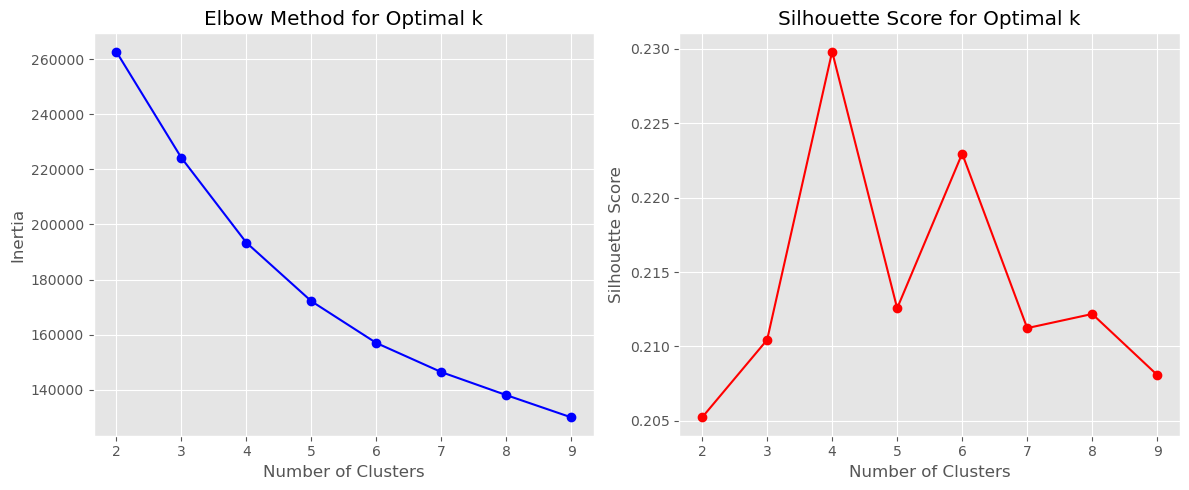

In [72]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_avg, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)

plt.tight_layout()
plt.show()


From the **silhouette score plot**, we can see that:

The highest silhouette score occurs at k=4 clusters. There's a secondary peak at k=6 clusters. The scores generally decrease after k=6

From the **elbow method** plot:

There's no sharp "elbow" point, but there's a gradual decrease in inertia. The rate of decrease noticeably slows around k=4 to k=5

Given these observations, **k=4 appears to be the optimal choice** 

In [73]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(features_scaled)

cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_), 
    columns=features.columns
)
print("\nCluster Centers:")
display(cluster_centers)


Cluster Centers:


direct_distance_km  trip_duration_min  avg_speed_kmh  transport_type_code  \
0            7.288520          22.691186      20.226426             0.902816   
1            2.647106          10.021272      16.666801             0.824825   
2            3.118071          11.107689      17.348273             0.801027   
3            2.014908           9.197925      13.991220             2.684802   

    is_transfer  hour_of_day  
0  2.034468e-01     9.820177  
1  2.986500e-14    10.672575  
2  1.000000e+00    11.252833  
3  3.572330e-01    10.990406

1. **transport_type_code**: This column was originally encoded as 0 (bus), 1 (metro), and 2 (trolleybus), 3 (tram). After clustering, we're seeing decimal values like 0.902816, which indicates that Cluster 0 contains a mix of transport types, leaning slightly toward metro (1). Cluster 3 with 2.684802 suggests it contains predominantly trolleybus and tram trips.

These "strange" values occur because cluster centers represent the average of all points in a cluster. 

### Cluster intrpretation 

- **Cluster 0**: Long-distance trips (7.3 km), longest duration (22.7 min), fastest speed (20.2 km/h), mix of transport types but mostly metro, 20% transfers, early morning (9.8 hour = 9:48 AM)

- **Cluster 1**: Medium-distance trips (2.6 km), medium duration (10 min), medium speed (16.7 km/h), mostly metro, virtually no transfers, mid-morning (10.7 hour)

- **Cluster 2**: Medium-distance trips (3.1 km), medium duration (11.1 min), medium-fast speed (17.3 km/h), mostly metro, 100% transfers, late morning (11.3 hour)

- **Cluster 3**: Short-distance trips (2 km), shortest duration (9.2 min), slowest speed (14 km/h), predominantly trolley and tram, 36% transfers, mid-morning (11 hour)

## DBSCAN Clustering
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) because:
- It can discover clusters of arbitrary shape, which is valuable for temporal patterns in transport data
- It doesn't require pre-specifying the number of clusters
- It effectively identifies outliers as "noise" points, which helps isolate unusual travel patterns

In [74]:
# For large datasets, we're using a sample for initial parameter tuning
sample_size = 5000  # Use a 5000-point sample for initial tuning
sample_indices = np.random.choice(len(df), sample_size, replace=False)
df_sample = df.iloc[sample_indices].copy()

features_cols = [
    'direct_distance_km',
    'trip_duration_min', 
    'avg_speed_kmh',
    'transport_type_code',
    'is_transfer',
    'hour_of_day', 
]

features_sample = df_sample[features_cols]
scaler = StandardScaler()
features_sample_scaled = scaler.fit_transform(features_sample)

# For a large dataset, appropriate parameter ranges:
# 1. eps: Should be smaller than for small datasets
# 2. min_samples: Should be larger to avoid excessive fragmentation

eps_values = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
min_samples_values = [10, 20, 50, 100, 200]

print(f"Testing {len(eps_values) * len(min_samples_values)} parameter combinations on {sample_size} sample points...")

results = []

# grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(features_sample_scaled)
        
        # number of clusters excluding noise points with label -1
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # skip cases with 1 cluster or all points as noise
        if n_clusters < 2 or n_noise == len(labels):
            silhouette = np.nan
        else:
            # filter out noise points for silhouette calculation
            mask = labels != -1
            try:
                silhouette = silhouette_score(features_sample_scaled[mask], labels[mask])
            except:
                silhouette = np.nan
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(labels),
            'silhouette': silhouette
        })


results_df = pd.DataFrame(results)

print("Top DBSCAN Parameter Combinations:")
display(results_df.sort_values('silhouette', ascending=False).head(10))

Testing 30 parameter combinations on 5000 sample points...
Top DBSCAN Parameter Combinations:


eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
17  0.5           50           2     4878       0.9756    0.367025
28  1.0          100           2     2086       0.4172    0.274956
22  0.7           50           4     2608       0.5216    0.256140
10  0.3           10          24     4250       0.8500    0.170623
21  0.7           20           7     1151       0.2302    0.127688
26  1.0           20           8      375       0.0750    0.126463
27  1.0           50           7      945       0.1890    0.123067
20  0.7           10          10      597       0.1194    0.122569
16  0.5           20           6     2892       0.5784    0.121187
25  1.0           10           8      194       0.0388    0.119380

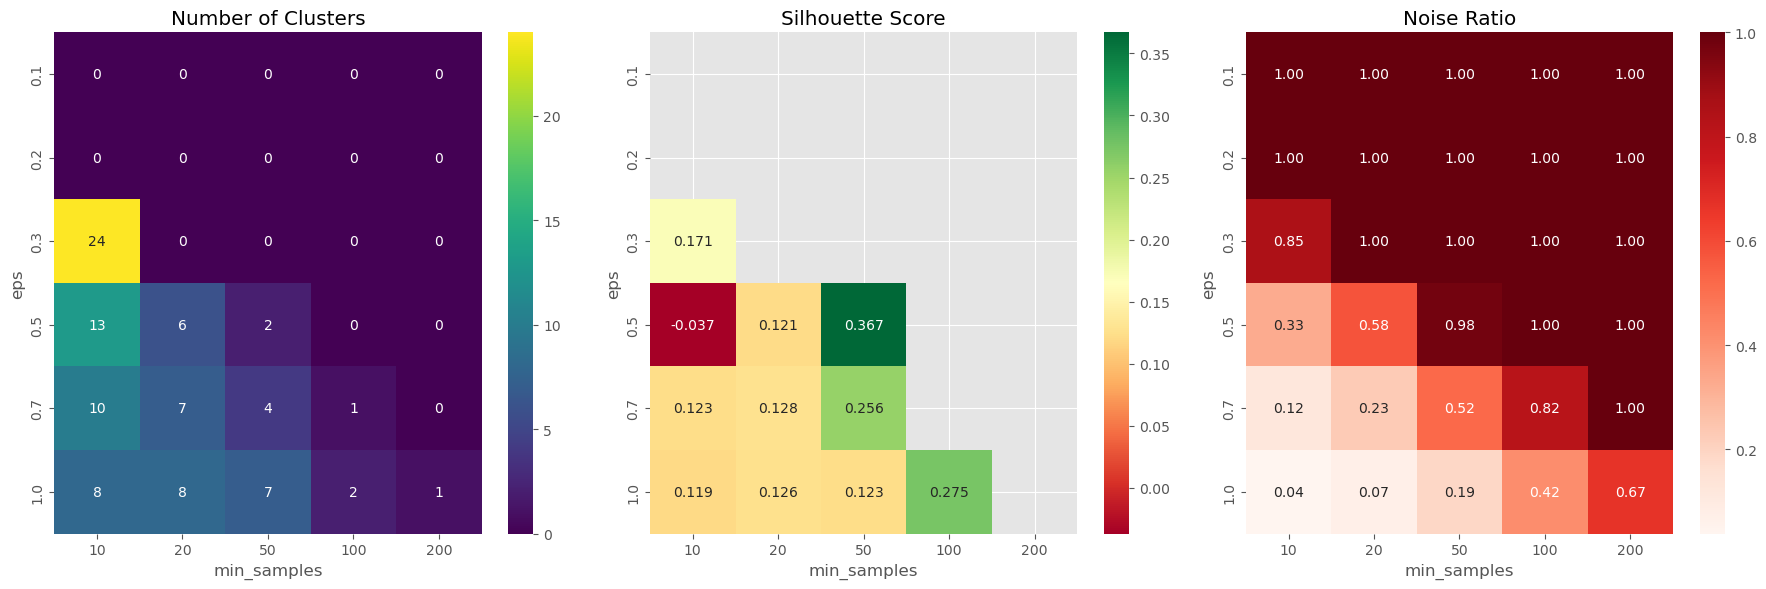

In [75]:

heatmap_clusters = results_df.pivot(index='eps', columns='min_samples', values='n_clusters')
heatmap_silhouette = results_df.pivot(index='eps', columns='min_samples', values='silhouette')
heatmap_noise = results_df.pivot(index='eps', columns='min_samples', values='noise_ratio')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(heatmap_clusters, annot=True, cmap='viridis', ax=axes[0], fmt='d')
axes[0].set_title('Number of Clusters')
axes[0].set_xlabel('min_samples')
axes[0].set_ylabel('eps')

# Silhouette score
sns.heatmap(heatmap_silhouette, annot=True, cmap='RdYlGn', ax=axes[1], fmt='.3f')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('min_samples')
axes[1].set_ylabel('eps')

# Noise ratio
sns.heatmap(heatmap_noise, annot=True, cmap='Reds', ax=axes[2], fmt='.2f')
axes[2].set_title('Noise Ratio')
axes[2].set_xlabel('min_samples')
axes[2].set_ylabel('eps')

plt.tight_layout()
plt.show()

In [76]:
# Filter results - not too many/few clusters, not too much noise
filtered_results = results_df[
    (results_df['n_clusters'] >= 3) & 
    (results_df['n_clusters'] <= 10) & 
    (results_df['noise_ratio'] < 0.3) &
    (~results_df['silhouette'].isna())
]
display(filtered_results.sort_values('silhouette', ascending=False))

eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
21  0.7           20           7     1151       0.2302    0.127688
26  1.0           20           8      375       0.0750    0.126463
27  1.0           50           7      945       0.1890    0.123067
20  0.7           10          10      597       0.1194    0.122569
25  1.0           10           8      194       0.0388    0.119380

In [77]:
if(not filtered_results.empty): 
        # Sort by silhouette score
        filtered_results = filtered_results.sort_values('silhouette', ascending=False).reset_index(drop=True)
        best_result = filtered_results.iloc[0]
        # Now apply to the full dataset
        print("\nApplying optimal parameters to full dataset...")
        
        # Prepare the full dataset
        features_full = df[features_cols]
        features_full_scaled = scaler.transform(features_full)
        
        optimal_dbscan = DBSCAN(
            eps=best_result['eps'], 
            min_samples=int(best_result['min_samples']),
            n_jobs=-1  # Use all available cores for faster processing
        )
        df['dbscan_cluster'] = optimal_dbscan.fit_predict(features_full_scaled)
        
        n_clusters_full = len(set(df['dbscan_cluster'])) - (1 if -1 in df['dbscan_cluster'] else 0)
        n_noise_full = list(df['dbscan_cluster']).count(-1)
        
        print(f"Number of clusters in full dataset: {n_clusters_full}")
        print(f"Noise points in full dataset: {n_noise_full} ({n_noise_full/len(df):.2%})")
        
        cluster_sizes = df['dbscan_cluster'].value_counts().sort_index()
        print("\nCluster sizes:")
        display(cluster_sizes)
        
        try:
            cluster_stats = df.groupby('dbscan_cluster').agg({
                'direct_distance_km': ['mean', 'std'],
                'trip_duration_min': ['mean', 'std'],
                'avg_speed_kmh': ['mean', 'std'],
                'is_transfer': 'mean',
                'hour_of_day': 'mean'
            })
            
            print("\nCluster statistics:")
            display(cluster_stats)
        except:
            print("Could not calculate all cluster statistics. Adjust the column names as needed.")


Applying optimal parameters to full dataset...
Number of clusters in full dataset: 10
Noise points in full dataset: 1063 (1.90%)

Cluster sizes:


dbscan_cluster
-1     1063
 0     3692
 1    24943
 2     2173
 3     1154
 4     4851
 5    12672
 6     2059
 7     3340
 8       28
Name: count, dtype: int64


Cluster statistics:


direct_distance_km           trip_duration_min             \
                             mean       std              mean        std   
dbscan_cluster                                                             
-1                       7.347782  4.404736         24.439284  15.892683   
 0                       2.886126  2.160586         11.184499   7.178226   
 1                       4.134472  2.557188         13.594033   6.863517   
 2                       2.504481  1.612838         11.276460   7.432770   
 3                       2.149410  1.382308          9.197708   5.843923   
 4                       3.140819  2.313891         12.954868   9.530624   
 5                       3.868322  2.132192         12.968212   5.935597   
 6                       1.932517  1.297943          8.611904   5.866159   
 7                       2.230385  1.494415         10.111399   7.020781   
 8                       8.551643  0.466971         45.642064   2.667642   

               avg_speed_kmh            is_transfer hour_of_day  
                        mean        std        mean        mean  
dbscan_cluster                                                   
-1                 22.922333  10.512042    0.608655   11.669802  
 0                 15.783792   5.290962    1.000000   11.146804  
 1                 18.189080   6.407091    0.000000   10.417151  
 2                 14.115128   4.351840    0.000000   10.803037  
 3                 14.585703   4.155787    1.000000   11.487868  
 4                 15.420983   5.587265    0.000000   10.179551  
 5                 18.039500   6.473356    1.000000   11.038668  
 6                 14.361062   5.226110    1.000000   11.338514  
 7                 14.122665   5.002640    0.000000   10.597006  
 8                 11.287417   1.000630    1.000000   12.571429

# Conclusion

This analysis of Sofia's public transport system reveals distinct usage patterns characterized by four primary journey profiles, with metro being the dominant transit mode and showing clear morning and mid-day peak periods, due to the weekend. The clustering methods effectively identified trip segments ranging from long-distance, high-speed metro journeys to shorter, slower surface transit trips, providing valuable insights for future service planning and optimization.